In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_test, x_test, ids_test, header = helper.load_csv_data(DATA_TEST)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y,0.2);

In [2]:
x_train[x_train == -999] = np.nan
x_test[x_test == -999] = np.nan
x_validation[x_validation == -999] = np.nan

In [3]:
tags, count = np.unique(x_train[:, 22], return_counts=True)
repart_jet = count/len(y_train)
print('Repartition of #jet {} along data {}%'.format(tags, 100*repart_jet))

Repartition of #jet [ 0.  1.  2.  3.] along data [ 39.656  31.362  20.138   8.844]%


In [4]:
for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [13.1340, 945.5550]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0010, 511.4080]
Feature 3 - DER_mass_vis has range: [9.4950, 1034.2050]
Feature 4 - DER_pt_h has range: [0.0000, 762.8060]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [15.3190, 4974.9790]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 14.7000]
Feature 8 - DER_deltar_tau_lep has range: [0.3460, 5.5460]
Feature 9 - DER_pt_tot has range: [0.0000, 371.8760]
Feature 10 - DER_sum_pt has range: [46.3130, 1703.7520]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0800, 19.7730]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 505.0600]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4940]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 426.3980]
Feat

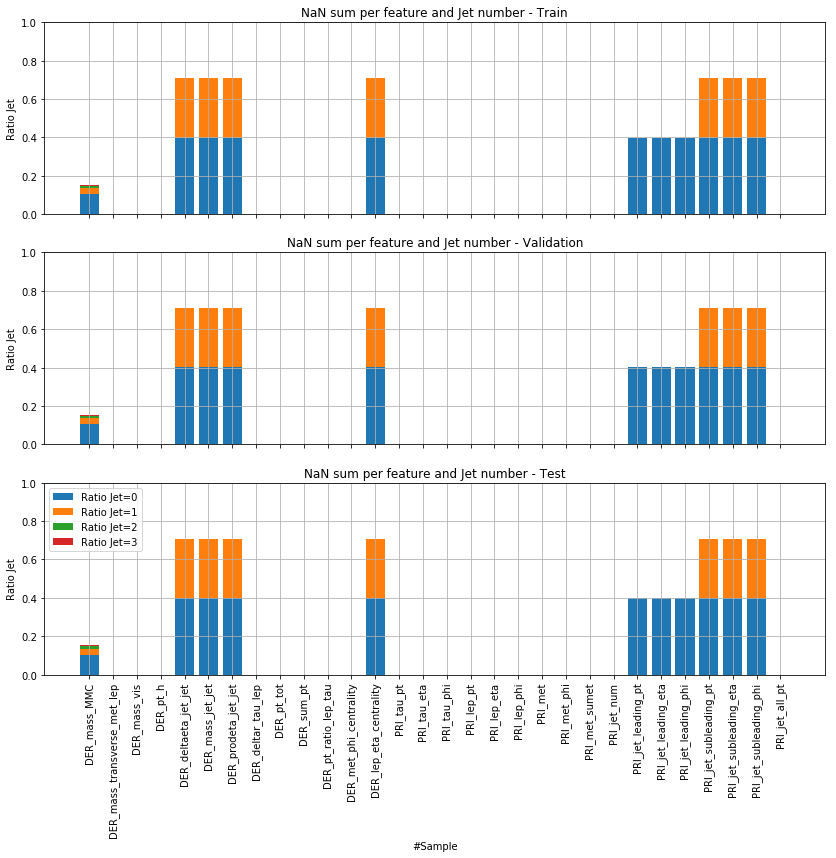

In [5]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(14, 12))
nan_j_tr = []; nan_j_val = []; nan_j_te = []
for i in range(4):
    nan_j_tr.append(np.array([ 
        np.sum(np.logical_and(x_train[:, 22] == i, np.isnan(f))) for f in x_train.T])/len(y_train))
    nan_j_val.append(np.array([
        np.sum(np.logical_and(x_validation[:, 22] == i, np.isnan(f))) for f in x_validation.T])/len(y_validation))
    nan_j_te.append(np.array([
        np.sum(np.logical_and(x_test[:, 22] == i, np.isnan(f))) for f in x_test.T])/len(y_test))
    axes[0].bar(np.arange(len(header)), nan_j_tr[-1], 
            label='Ratio Jet={}'.format(i), bottom = np.sum(np.array(nan_j_tr[:-1]), axis=0))
    axes[1].bar(np.arange(len(header)), nan_j_val[-1], 
            label='Ratio Jet={}'.format(i), bottom = np.sum(np.array(nan_j_val[:-1]), axis=0))
    axes[2].bar(np.arange(len(header)), nan_j_te[-1], 
            label='Ratio Jet={}'.format(i), bottom = np.sum(np.array(nan_j_te[:-1]), axis=0))
    
plt.xticks(np.arange(len(header)), header, rotation='vertical'); 
axes[0].set_ylim(0, 1); 
axes[0].set_ylabel('Ratio Jet'); axes[1].set_ylabel('Ratio Jet'); axes[2].set_ylabel('Ratio Jet'); 
axes[0].grid(); axes[1].grid(); axes[2].grid()
plt.xlabel('Features'); plt.xlabel('#Sample'); 
axes[0].set_title('NaN sum per feature and Jet number - Train')
axes[1].set_title('NaN sum per feature and Jet number - Validation')
axes[2].set_title('NaN sum per feature and Jet number - Test')
plt.legend(); plt.show()

In [31]:
from scripts.ml import augmented_feat_angle

def get_data_jet(y, x, id_current_jet, id_jet=22):
    id_select = (x[:, id_jet] == id_current_jet)
    x_jet = x[id_select, :]
    y_jet = y[id_select]

    jet_keep = np.arange(x.shape[1]) != id_jet
    no_nan_keep = ~np.any(np.isnan(x_jet), axis=0)
    return id_select, y_jet, x_jet[:, np.logical_and(jet_keep, no_nan_keep) ]
   
models = []
for i in range(4):
    _, y_train_j, x_train_j = get_data_jet(y_train, x_train, i)
    _, y_validation_j, x_validation_j = get_data_jet(y_validation, x_validation, i)
    id_test, y_test_j, x_test_j = get_data_jet(y_test, x_test, i)
    # Last vector is only 0's for #jet == 0, we remove it
    if i != 0:
        x_train_j = (x_train_j - np.mean(x_train_j, axis=0))/np.std(x_train_j, axis=0)
        x_validation_j = (x_validation_j - np.mean(x_validation_j, axis=0))/np.std(x_validation_j, axis=0)
        x_test_j = (x_test_j - np.mean(x_test_j, axis=0))/np.std(x_test_j, axis=0)
    else:
        x_train_j = (x_train_j[:, :-1] - np.mean(x_train_j[:, :-1], axis=0))/np.std(x_train_j[:, :-1], axis=0)
        x_validation_j = (x_validation_j[:, :-1] - np.mean(x_validation_j[:, :-1], axis=0))/np.std(x_validation_j[:, :-1], axis=0)
        x_test_j = (x_test_j[:, :-1] - np.mean(x_test_j[:, :-1], axis=0))/np.std(x_test_j[:, :-1], axis=0)
        
    models.append( {'y_train': y_train_j, 'x_train': x_train_j, 
                    'y_validation': y_validation_j, 'x_validation': x_validation_j,
                    'y_test': y_test_j, 'x_test': x_test_j, 'id_test': id_test} )
    
    print(len(models[i]['id_test']))
    


568238
568238
568238
568238


In [32]:
def plot_train_test(train_errors, test_errors, lambdas, degree):
    """
    train_errors, test_errors and lambas should be list (of the same size) the respective train error and test error for a given lambda,
    * lambda[0] = 1
    * train_errors[0] = RMSE of a ridge regression on the train set
    * test_errors[0] = RMSE of the parameter found by ridge regression applied on the test set
    
    degree is just used for the title of the plot.
    """
    plt.semilogx(lambdas, train_errors, color='b', marker='*', label="Train error")
    plt.semilogx(lambdas, test_errors, color='r', marker='*', label="Test error")
    plt.xlabel("lambda")
    plt.ylabel("RMSE")
    plt.title("Ridge regression for polynomial degree " + str(degree))
    leg = plt.legend(loc=1, shadow=True)
    leg.draw_frame(False)
    plt.savefig("ridge_regression")
    
def test_ridge_regression(x, y, x_val, y_val, degrees, lambdas):
    
    best_acc = 0
    best_degree = 0
    best_lambda = 0
    best_rmse_tr = []
    best_rmse_te = []
    best_weights = []
    for degree in degrees:
        degree = int(degree)
        #lambdas = np.logspace(-7, 2, 20)

        # Split sets
        #x_train, x_test, y_train, y_test = split_data(x, y, ratio, seed)

        # Get ploynomial
        phi_train = lib.build_poly(x, degree)
        phi_test = lib.build_poly(x_val, degree)

        rmse_tr = []
        rmse_te = []
        update_rmse = False

        for ind, lambda_ in enumerate(lambdas):

            mse_tr, weights = lib.ridge_regression(y, phi_train, lambda_)
            mse_te = lib.compute_loss(y_val, phi_test.dot(weights))
            rmse_tr.append(np.sqrt(2*mse_tr))
            rmse_te.append(np.sqrt(2*mse_te))

            print("degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
                    d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
            print('train acc : ', lib.accuracy(y, phi_train.dot(weights)))
            val_acc = lib.accuracy(y_val, phi_test.dot(weights))
            print('validation acc : ', val_acc)

            if(val_acc > best_acc):
                best_acc = val_acc
                best_degree = degree
                best_lambda = lambda_
                best_weights = weights
                update_rmse = True
        
        if(update_rmse):
            best_rmse_tr = rmse_tr
            best_rmse_te = rmse_te

        # Plot the best obtained results
    plot_train_test(best_rmse_tr, best_rmse_te, lambdas, best_degree)

    print('Best params for Ridge regression : degree = ',best_degree, ', lambda = ',best_lambda,', accuracy = ', best_acc)
    
    return best_weights, best_degree, best_lambda

************ Model 1 ************* 
degree=8, lambda=0.000, Training RMSE=0.686, Testing RMSE=119624620984.629
train acc :  0.841587653823
validation acc :  0.802722107761
degree=8, lambda=0.000, Training RMSE=0.701, Testing RMSE=119634554432.876
train acc :  0.840528545491
validation acc :  0.687856652307
degree=8, lambda=0.000, Training RMSE=0.687, Testing RMSE=119647366310.012
train acc :  0.841638087553
validation acc :  0.52717737404
degree=8, lambda=0.000, Training RMSE=0.688, Testing RMSE=119627597430.340
train acc :  0.842142424854
validation acc :  0.561503402635
degree=8, lambda=0.000, Training RMSE=0.688, Testing RMSE=119648140228.999
train acc :  0.840831147872
validation acc :  0.827370918399
degree=8, lambda=0.000, Training RMSE=0.686, Testing RMSE=119636545303.798
train acc :  0.842445027234
validation acc :  0.747305987388
degree=8, lambda=0.000, Training RMSE=0.685, Testing RMSE=119638622936.113
train acc :  0.842142424854
validation acc :  0.826109758382
degree=8, lam

validation acc :  0.835312480489
degree=8, lambda=0.001, Training RMSE=0.698, Testing RMSE=97512578861.886
train acc :  0.832812184789
validation acc :  0.833864019479
degree=8, lambda=0.001, Training RMSE=0.701, Testing RMSE=106958953079.265
train acc :  0.831198305427
validation acc :  0.832527939065
degree=8, lambda=0.002, Training RMSE=0.704, Testing RMSE=114493736939.995
train acc :  0.829735727254
validation acc :  0.830854716863
degree=8, lambda=0.002, Training RMSE=0.707, Testing RMSE=119637269188.118
train acc :  0.828575751463
validation acc :  0.829593556846
degree=8, lambda=0.002, Training RMSE=0.710, Testing RMSE=122059145630.600
train acc :  0.82706273956
validation acc :  0.827733033652
degree=8, lambda=0.002, Training RMSE=0.713, Testing RMSE=121601109225.183
train acc :  0.824793221707
validation acc :  0.82605981145
degree=8, lambda=0.002, Training RMSE=0.716, Testing RMSE=118284602851.721
train acc :  0.823078474884
validation acc :  0.82461135044
degree=8, lambda=0.

degree=9, lambda=0.000, Training RMSE=0.685, Testing RMSE=24963582608768.398
train acc :  0.842545894694
validation acc :  0.842330024349
degree=9, lambda=0.000, Training RMSE=0.711, Testing RMSE=24939546077625.277
train acc :  0.83992334073
validation acc :  0.635200099894
degree=9, lambda=0.000, Training RMSE=0.688, Testing RMSE=24918325040676.383
train acc :  0.841537220093
validation acc :  0.734407192358
degree=9, lambda=0.000, Training RMSE=0.739, Testing RMSE=24892018703551.355
train acc :  0.843302400646
validation acc :  0.840207279765
degree=9, lambda=0.000, Training RMSE=0.684, Testing RMSE=24861193520010.902
train acc :  0.842596328424
validation acc :  0.740737965911
degree=9, lambda=0.000, Training RMSE=0.684, Testing RMSE=24829534921585.094
train acc :  0.842999798265
validation acc :  0.746931385403
degree=9, lambda=0.000, Training RMSE=0.688, Testing RMSE=24787243643281.293
train acc :  0.842394593504
validation acc :  0.827558219392
degree=9, lambda=0.000, Training RM

degree=9, lambda=0.020, Training RMSE=0.816, Testing RMSE=1095644990931.616
train acc :  0.790901755094
validation acc :  0.792670287819
degree=9, lambda=0.022, Training RMSE=0.822, Testing RMSE=1380450443317.643
train acc :  0.789338309461
validation acc :  0.791034525816
degree=9, lambda=0.025, Training RMSE=0.827, Testing RMSE=1595654318399.700
train acc :  0.787926165019
validation acc :  0.789448710745
degree=9, lambda=0.028, Training RMSE=0.832, Testing RMSE=1743453723558.051
train acc :  0.787220092798
validation acc :  0.787675594681
degree=9, lambda=0.031, Training RMSE=0.836, Testing RMSE=1826330468044.089
train acc :  0.785505345975
validation acc :  0.785752637822
degree=9, lambda=0.035, Training RMSE=0.841, Testing RMSE=1847207437250.796
train acc :  0.782580189631
validation acc :  0.784091902354
degree=9, lambda=0.039, Training RMSE=0.846, Testing RMSE=1809742545585.877
train acc :  0.781168045189
validation acc :  0.782044078167
degree=9, lambda=0.044, Training RMSE=0.8

degree=10, lambda=0.000, Training RMSE=37.971, Testing RMSE=293878594255892.312
train acc :  0.754539035707
validation acc :  0.471661359805
degree=10, lambda=0.000, Training RMSE=7.640, Testing RMSE=292946602751953.938
train acc :  0.78843050232
validation acc :  0.556596116626
degree=10, lambda=0.000, Training RMSE=20.521, Testing RMSE=602211251321225.000
train acc :  0.80759531975
validation acc :  0.716238996067
degree=10, lambda=0.000, Training RMSE=11.466, Testing RMSE=615005223726902.375
train acc :  0.803611055074
validation acc :  0.463994505838
degree=10, lambda=0.000, Training RMSE=7.079, Testing RMSE=713023955869349.000
train acc :  0.80794835586
validation acc :  0.562664668789
degree=10, lambda=0.000, Training RMSE=26.230, Testing RMSE=740617488534743.000
train acc :  0.749546096429
validation acc :  0.550377723669
degree=10, lambda=0.000, Training RMSE=0.922, Testing RMSE=818343915350090.125
train acc :  0.708745208796
validation acc :  0.549353811575
degree=10, lambda=0

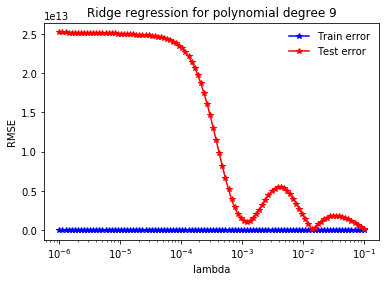

In [33]:

for i, model in enumerate(models):
    if i != 0:
        break;
    print('************ Model {} ************* '.format(i+1))
    weights_no_nan, degree_no_nan, lambda_no_nan = test_ridge_regression(
        model['x_train'], model['y_train'], model['x_validation'], model['y_validation'], 
        degrees = np.linspace(8,10,3), lambdas=np.logspace(-6,-1, 100))

In [9]:
# Model 1:
# Best params for Ridge regression : degree =  9 , lambda =  0.000206913808111 , accuracy =  0.842567272273
# Best params for Ridge regression : degree =  9 , lambda =  0.00016681005372 , accuracy =  0.842804520197
# Model 2:
# Best params for Ridge regression : degree =  7 , lambda =  0.000615848211066 , accuracy =  0.779464300147
# Best params for Ridge regression : degree =  7 , lambda =  0.000661474064123 , accuracy =  0.779415805894
# Model 3:
# Best params for Ridge regression : degree =  9 , lambda =  0.000615848211066 , accuracy =  0.803870007442
# Best params for Ridge regression : degree =  9 , lambda =  0.000272833337649 , accuracy =  0.805284048623
# Model 4:
# Best params for Ridge regression : degree =  8 , lambda =  0.000615848211066 , accuracy =  0.789595310563
# Best params for Ridge regression : degree =  8 , lambda =  0.000366524123708 , accuracy =  0.790046218014

acc = np.array([0.842567272273, 0.779464300147, 0.805284048623, 0.790046218014])
print('Accuracy = {}'.format(acc.dot(repart_jet)))

Accuracy = 0.8106238605375409


In [15]:
from scripts.implementations import build_poly, least_squares, accuracy
from scripts.proj1_helpers import predict_labels

y_pred = np.zeros(len(y_test))
best_degrees = [9, 7, 9, 8]
best_lambda = [0.000206913808111, 0.000615848211066, 0.000272833337649, 0.000366524123708]
for i, model in enumerate(models):
    
    phi_train = lib.build_poly(model['x_train'], best_degrees[i])
    phi_test = lib.build_poly(model['x_test'], best_degrees[i])
    mse_tr, weights = lib.ridge_regression(model['y_train'], phi_train, best_lambda[i])
    y_pred[model['id_test']] = predict_labels(weights, phi_test)
    print(mse_tr)
    print(len(y_pred), len(model['id_test']))

0.233524097725
568238 568238
0.312458238802
568238 568238
0.276830947233
568238 568238
0.285257530654
568238 568238


In [17]:
from scripts.proj1_helpers import create_csv_submission

create_csv_submission(ids_test, y_pred, 'submission.csv')
print('Results saved ...')

Results saved ...
